In [1]:
from dolfinx import geometry, fem, mesh, plot, io
from mpi4py import MPI
from petsc4py.PETSc import ScalarType, ComplexType
from ufl import (TrialFunction, Measure, TestFunction, dx, ds, grad, div, inner, lhs, rhs)

import timeit
import numpy as np
import pandas as pd

from utils.dolfinx import BoundaryCondition, generate_boundary_measure, eval_pointvalues, project
from utils.plotting import Mpl2DPlotter

from pathlib import Path

In [2]:
save_dir = "./results/2d-homogeneous-with-dissipation"
Path(save_dir).mkdir(parents=True, exist_ok=True)

In [3]:
def generate_boundaries(points):
    return [(1, lambda x: np.isclose(x[0], points[0][0])),
            (2, lambda x: np.isclose(x[0], points[0][1])),
            (3, lambda x: np.isclose(x[1], points[1][0])),
            (4, lambda x: np.isclose(x[1], points[1][1])),]

In [4]:
def problem_setup(N: int,
                  points,
                  fluid: str, 
                  freq: float, 
                  pressure):
    """
    Performs problem configuration w.r.t. given parameters
    """
    
    # Mesh and function space definition
    domain = mesh.create_rectangle(
        MPI.COMM_WORLD, 
        [(points[0][0], points[1][0]), (points[0][1], points[1][1])], 
        N
    )
    V = fem.VectorFunctionSpace(domain, ("CG", 2))

    u = TrialFunction(V)
    v = TestFunction(V)
    
    # Definition of density and speed functions
    ro, c, eta = fluids.loc[fluid, ['Density', 'Speed of sound', 'Viscosity']]
    omega = freq * 2 * np.pi
        
    # Construction of bilinear form and linear functional
    aa = ScalarType(ro * c**2) * inner(grad(u), grad(v)) * dx
    mm = ScalarType(ro) * inner(u, v) * dx
    cc = ScalarType(4./3 * eta) * inner(grad(u), grad(v)) * dx
    

    F = aa - omega**2 * mm + omega * 1.0j * cc
    
    boundaries = generate_boundaries(points)
    measure = generate_boundary_measure(boundaries, domain)
    
    u_D = lambda x: [x[0] * 0.0, x[1] * 0.0]
    u_N = fem.Constant(domain, ScalarType(pressure))
    
    boundary_conditions = [BoundaryCondition("Dirichlet", 1, u_D, V, u, v, measure),
                           BoundaryCondition("Neumann", 2, u_N, V, u, v, measure),
                           BoundaryCondition("Dirichlet", 3, u_D, V, u, v, measure), 
                           BoundaryCondition("Dirichlet", 4, u_D, V, u, v, measure)]
    
    bcs = []
    for condition in boundary_conditions:
        if condition.type == "Dirichlet":
            bcs.append(condition.bc)
        else:
            F += condition.bc
    
    Left = lhs(F)
    Right = rhs(F)
    
    return {
        'Params': (N, points, fluid, omega, pressure, ro, c, eta),
        'FunctionSpace': (domain, V, u, v),
        'Problem': (Left, Right, bcs)
    }

#### Available fluids

In [5]:
fluids = pd.read_csv('../data/physical_properties.csv', sep=';', index_col='Fluid')
fluids

,Density,Speed of sound,Viscosity
Fluid,,,
Water,1000,1500,0.000894
Fuel oil,890,1360,2.022000
Oil,760,1470,0.000500
Glycerin,1260,1905,1.500000


## Example 1

In [6]:
config = problem_setup(N=[40, 40], 
                       points=[[0.0, 0.002], [0.0, 0.002]],
                       fluid='Fuel oil',
                       freq=1e6,
                       pressure=(-1.0, 0))

N, points, fluid, omega, pressure, density, speed, viscosity = config['Params']
domain_1, V, u, v = config['FunctionSpace']
Left, Right, bcs = config['Problem']

In [7]:
problem = fem.petsc.LinearProblem(Left, Right, bcs)
uh_1 = problem.solve()

In [8]:
p_1 = project(density * speed**2 * div(uh_1), domain_1, ("DG", 0))

## Results

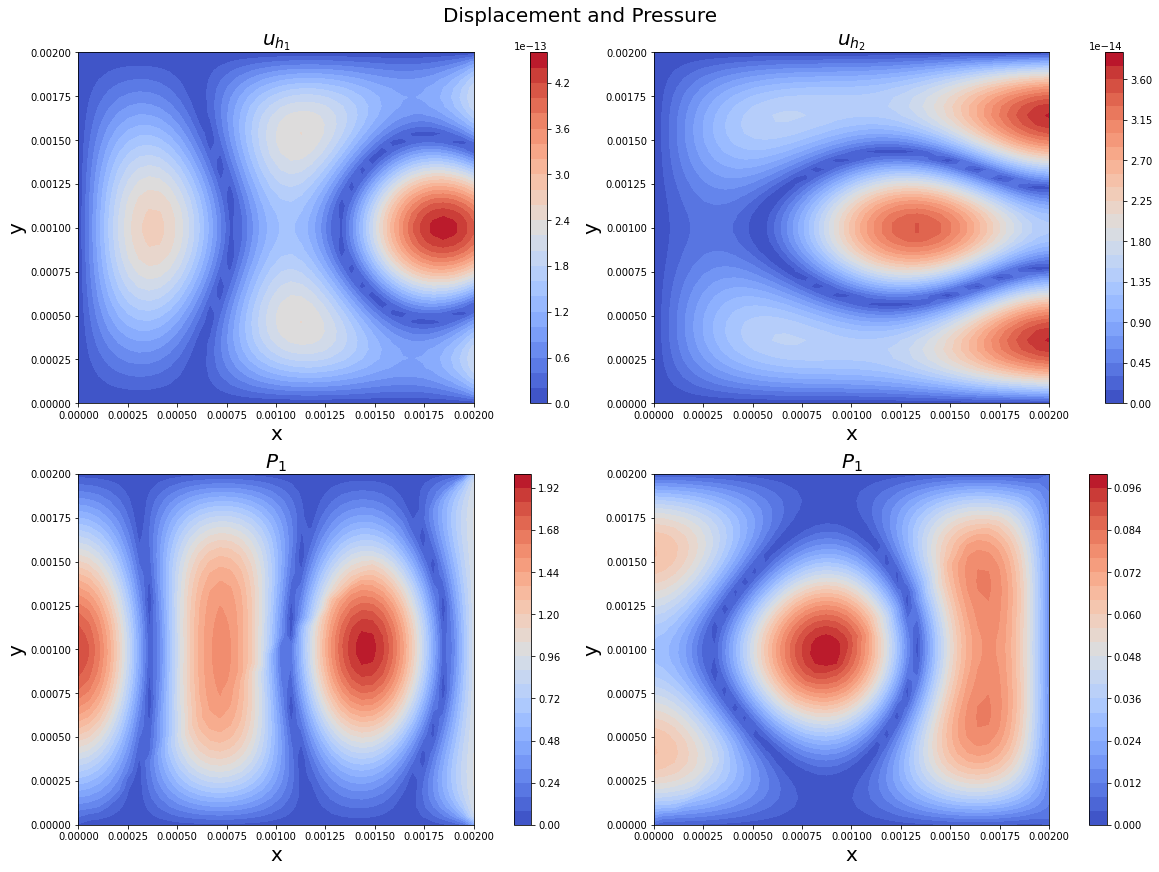

In [9]:
mpl = Mpl2DPlotter(layout=[['1', '2'], ['3', '4']], projection='2d')
mpl.update_figure(figsize=(16, 12), fontsize=20, suptitle="Displacement and Pressure")
mpl.plot(fun=uh_1, type='real', points=points, N=N, axes_id='1', title=r'$u_{h_1}$')
mpl.plot(fun=uh_1, type='imag', points=points, N=N, axes_id='2', title=r'$u_{h_2}$')
mpl.plot(fun=p_1, type='real', points=points, N=N, axes_id='3', title=r'$P_1$')
mpl.plot(fun=p_1, type='imag', points=points, N=N, axes_id='4', title=r'$P_1$')
mpl.save(f'{save_dir}/example_1_2d.svg')

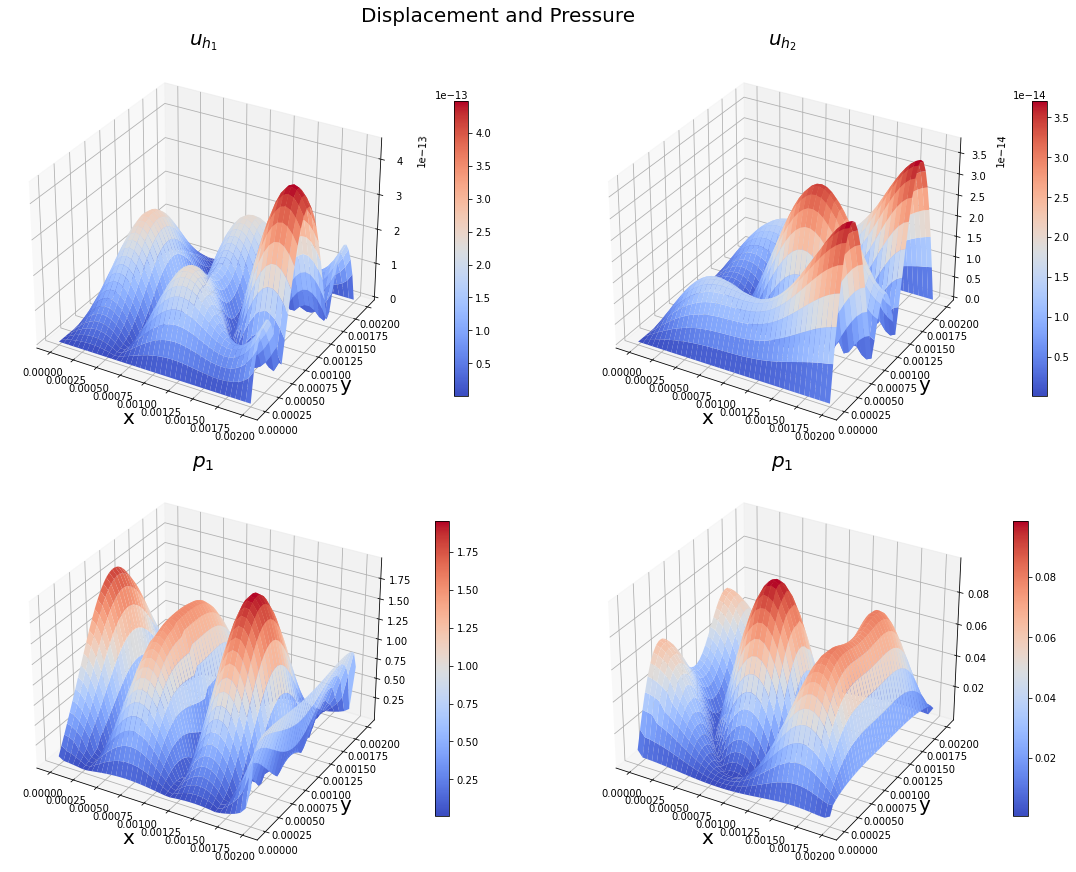

In [10]:
mpl = Mpl2DPlotter(layout=[['1', '2'], ['3', '4']], projection='3d')
mpl.update_figure(figsize=(16, 12), fontsize=20, suptitle="Displacement and Pressure")
mpl.plot(fun=uh_1, type='real', points=points, N=N, axes_id='1', title=r'$u_{h_1}$')
mpl.plot(fun=uh_1, type='imag', points=points, N=N, axes_id='2', title=r'$u_{h_2}$')
mpl.plot(fun=p_1, type='real', points=points, N=N, axes_id='3', title=r'$p_1$')
mpl.plot(fun=p_1, type='imag', points=points, N=N, axes_id='4', title=r'$p_1$')
mpl.save(f'{save_dir}/example_1_3d.svg')

## Example 2

In [11]:
config = problem_setup(N=[75, 75], 
                       points=[[0.0, 0.002], [0.0, 0.002]],
                       fluid='Fuel oil',
                       freq=0.5e6,
                       pressure=(-1.0, 0))

N, points, fluid, omega, pressure, density, speed, viscosity = config['Params']
domain_2, V, u, v = config['FunctionSpace']
Left, Right, bcs = config['Problem']

In [12]:
problem = fem.petsc.LinearProblem(Left, Right, bcs)
uh_2 = problem.solve()

In [13]:
p_2 = project(density * speed**2 * div(uh_2), domain_2, ("DG", 0))

## Results

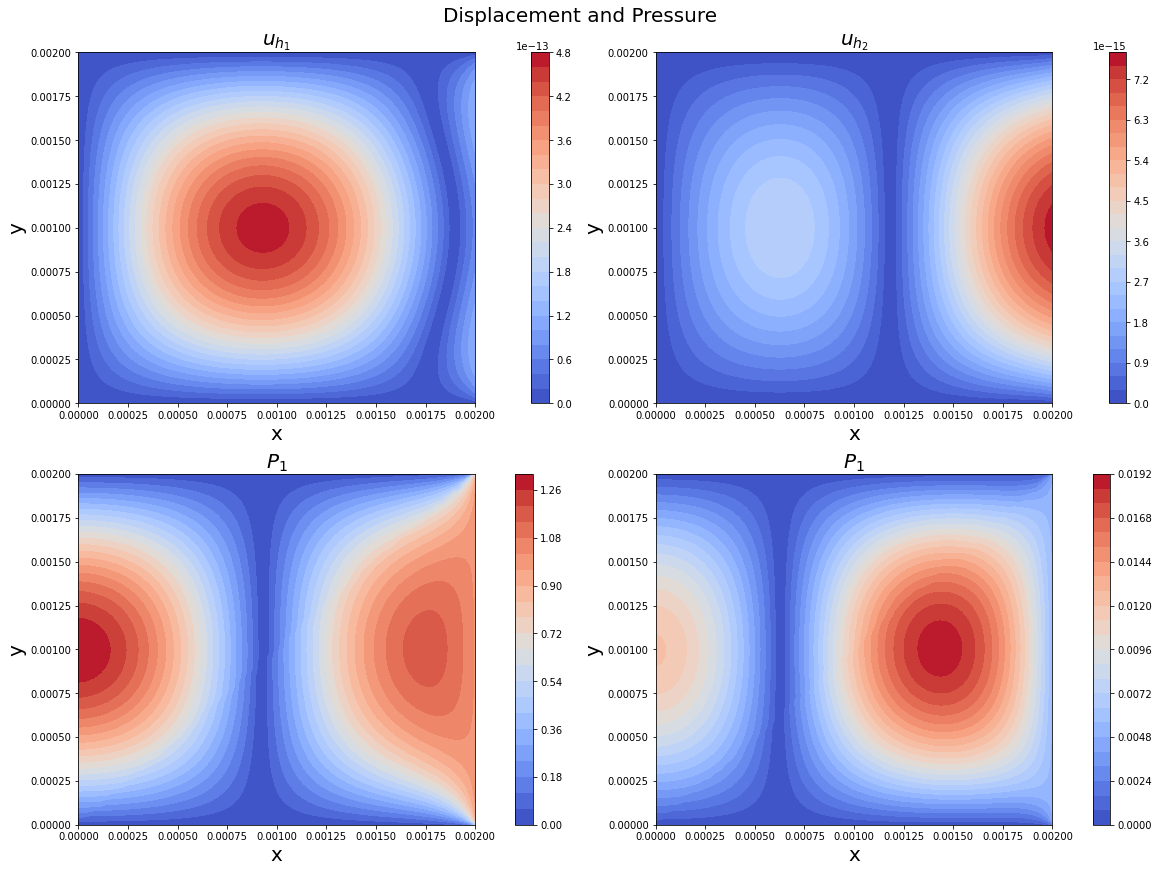

In [14]:
mpl = Mpl2DPlotter(layout=[['1', '2'], ['3', '4']], projection='2d')
mpl.update_figure(figsize=(16, 12), fontsize=20, suptitle="Displacement and Pressure")
mpl.plot(fun=uh_2, type='real', points=points, N=N, axes_id='1', title=r'$u_{h_1}$')
mpl.plot(fun=uh_2, type='imag', points=points, N=N, axes_id='2', title=r'$u_{h_2}$')
mpl.plot(fun=p_2, type='real', points=points, N=N, axes_id='3', title=r'$P_1$')
mpl.plot(fun=p_2, type='imag', points=points, N=N, axes_id='4', title=r'$P_1$')
mpl.save(f'{save_dir}/example_2_2d.svg')

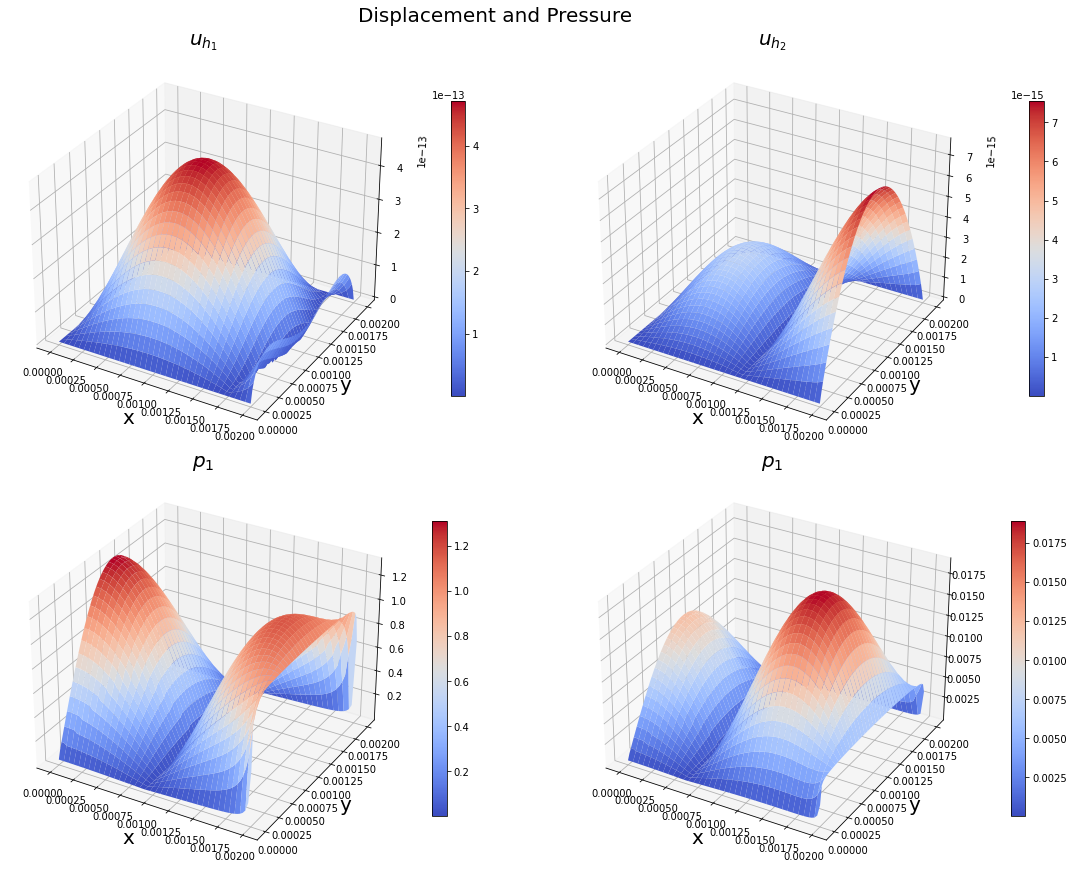

In [15]:
mpl = Mpl2DPlotter(layout=[['1', '2'], ['3', '4']], projection='3d')
mpl.update_figure(figsize=(16, 12), fontsize=20, suptitle="Displacement and Pressure")
mpl.plot(fun=uh_2, type='real', points=points, N=N, axes_id='1', title=r'$u_{h_1}$')
mpl.plot(fun=uh_2, type='imag', points=points, N=N, axes_id='2', title=r'$u_{h_2}$')
mpl.plot(fun=p_2, type='real', points=points, N=N, axes_id='3', title=r'$p_1$')
mpl.plot(fun=p_2, type='imag', points=points, N=N, axes_id='4', title=r'$p_1$')
mpl.save(f'{save_dir}/example_2_3d.svg')

### Save results

In [16]:
with io.XDMFFile(domain_1.comm, f"{save_dir}/data-uh_1.xdmf", "w") as xdmf:
    xdmf.write_mesh(domain_1)
    xdmf.write_function(uh_1)

with io.XDMFFile(domain_1.comm, f"{save_dir}/data-p_1.xdmf", "w") as xdmf:
    xdmf.write_mesh(domain_1)
    xdmf.write_function(p_1)
    
with io.XDMFFile(domain_2.comm, f"{save_dir}/data-uh_2.xdmf", "w") as xdmf:
    xdmf.write_mesh(domain_2)
    xdmf.write_function(uh_2)

with io.XDMFFile(domain_2.comm, f"{save_dir}/data-p_2.xdmf", "w") as xdmf:
    xdmf.write_mesh(domain_2)
    xdmf.write_function(p_2)